# Pixel Similarity (Notebook)
Supporting `Python` code for my **Medium article** and my **Presentation** for the UnpackAI week 5 deliverable.

>🚫 This notebook is not refactored yet, i.e. repeated code, bad variable names, lack of comments, etc. - so it might be hard for you to follow the code. However, you can run the cells from top to buttom. The data will be downloaded and stored in your root directory.

### Import Libraries

In [1]:
#dont change the order of importing!!
import torch.nn.functional as F
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
import numpy as np
import seaborn as sns
from sklearn import datasets, svm, metrics
from sklearn.metrics import confusion_matrix
matplotlib.rc('image', cmap='Greys')
%matplotlib inline

# Getting Data

In [2]:
# Download MNIST dataset
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [3]:
(path/"training"/"3").ls()

(#6131) [Path('training/3/49081.png'),Path('training/3/51816.png'),Path('training/3/39566.png'),Path('training/3/24251.png'),Path('training/3/20989.png'),Path('training/3/29013.png'),Path('training/3/58832.png'),Path('training/3/9294.png'),Path('training/3/20023.png'),Path('training/3/36899.png')...]

In [4]:
# Folder where data is stored on your computer
!ls ~/.fastai/data/mnist_png/training
#!ls ~/.fastai/data/mnist_png/training/0

0 1 2 3 4 5 6 7 8 9


In [5]:
threes=(path/"training"/"3").ls()
im3_path = threes[1]
Image.open(im3_path)

In [6]:
# Create Training Dataset for Demonstration
d = {}
n=0
#numbers = [zeros, ones, twos, threes, fours, fives, sixs, sevens, eights, nines]
numbers = "zeros,ones,twos,threes,fours,fives,sixs,sevens,eights,nines".split(",")
for number in numbers:
    var_name = "{}".format(number)
    d[var_name] = (path/'training'/str(n)).ls().sorted()[:100]
    n+=1
    d[var_name] = [tensor(Image.open(o)) for o in d[var_name]]

In [7]:
!pwd

/Users/dirkkalmbach/Library/Mobile Documents/com~apple~CloudDocs/Projekte/🎖🎓 Unpack AI/UnpackAI/dl101/week_5


### Visualize the data

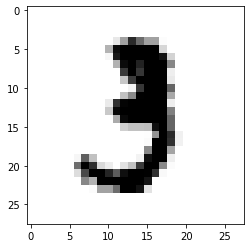

In [8]:
from matplotlib import pyplot as plt
plt.imshow(d["threes"][0])
plt.show()

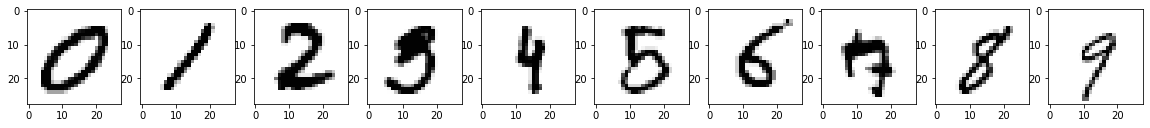

In [9]:
h=[]
for number in numbers:
    t=d[number][9]
    h.append(t)
    
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(h[i])

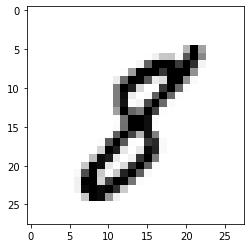

In [10]:
plt.imshow(h[8]);

## Create Dataset for Testing
>🧐 So we don't have to touch the training data (the data we build the _ideal_ digits from) when we calculate the classification accuracy.

In [11]:
# Create Dataset for Testing our results 
d_test = {}
n=0
numbers = "zeros,ones,twos,threes,fours,fives,sixs,sevens,eights,nines".split(",")
for number in numbers:
    var_name = "{}".format(number)
    d_test[var_name] = (path/'testing'/str(n)).ls().sorted()[:100] #<-now: /testing instead of /training
    n+=1
    d_test[var_name] = [tensor(Image.open(o)) for o in d_test[var_name]]

# Pixel Similarity

## 1. Build _ideal_ target digits for classifying images

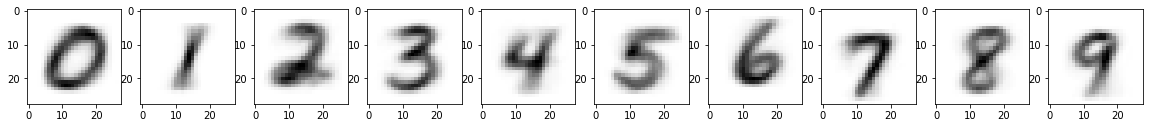

In [12]:
# Print "ideal" digits
h=[]
for number in numbers:
    t=d[number][0]/255
    for i in range(len(d[number])):
        t+=d[number][i]/255
    h.append(t)
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(h[i])

In [13]:
# Example for "ideal" digit 2 as a tensor
type(h[2])
tensor = torch.tensor(h[2], dtype=torch.int8)
tensor

<ipython-input-13-29781c24a83e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(h[2], dtype=torch.int8)


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  4,  7, 12, 14, 16, 16, 15, 12,  8,  6,  4,  2,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  2,  5, 11, 18, 30, 39, 46, 50, 49, 47, 38, 31, 23, 13,  6,  3,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  7, 15, 25, 35, 44, 56, 61, 63, 65, 65, 60, 48, 40, 29, 14,  6,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  4, 12, 21, 30, 39, 47, 53, 56, 58, 64, 66, 64, 57, 47, 38, 21,  7,  2,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  2,  5, 14, 20, 28, 35, 39, 45, 47, 52, 52, 52, 53, 54, 52, 40, 27,  8,  3,  0,  0,  0,  0],
        [ 0,  0,  0,  0,

## 2. Calculate Pixel Similarity

### Calculate L1-Loss

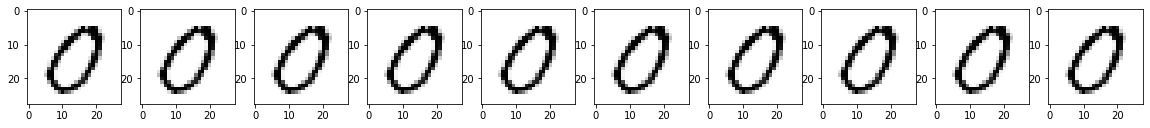

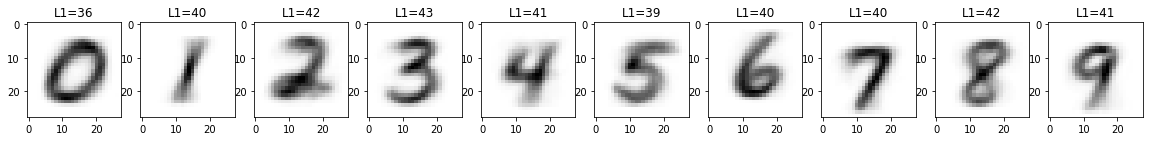

In [14]:
# Calculate L1-Loss
result=[]
zero = d_test["zeros"][5]
for i in range(0,10):
    result.append(int(F.l1_loss(h[i].float(), zero)))

#print(*result, sep='\t')

# Print "ideal" digits
h=[]
for number in numbers:
    t=d[number][0]/255
    for i in range(len(d[number])):
        t+=d[number][i]/255
    h.append(t)
# Plot 10x image to be classified
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(d_test["zeros"][4])
# Plot ideal images of digit with L1-Loss
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(h[i])
    axes[i].set_title("L1={}".format(result[i]))

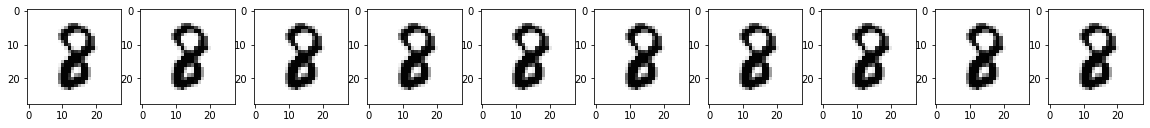

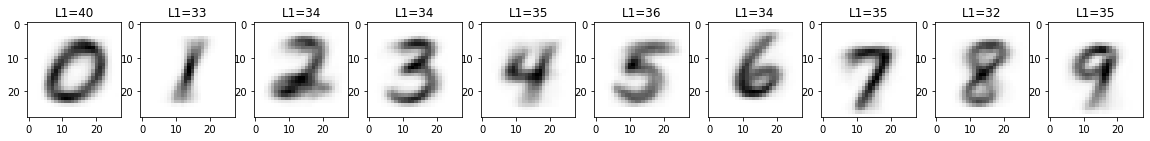

In [15]:
# Calculate L1-Loss
result=[]
zero = d_test["eights"][8]
for i in range(0,10):
    result.append(int(F.l1_loss(h[i].float(), zero)))
#print(*result, sep='\t')

# Print "ideal" digits
h=[]
for number in numbers:
    t=d[number][0]/255
    for i in range(len(d[number])):
        t+=d[number][i]/255
    h.append(t)
# Plot 10x image to be classified
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(d_test["eights"][8])
# Plot ideal images of digit with L1-Loss
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(h[i])
    axes[i].set_title("L1={}".format(result[i]))

### Caclulating L1 and L2 without the help of `torch.nn.functional` 

### Calculating for a single image

In [16]:
ideal_digits = h
img = d_test["threes"][1]#a_3

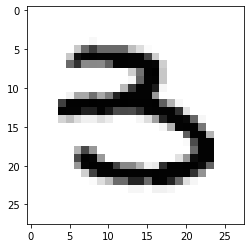

In [17]:
# Sample Image to be classified
plt.imshow(img);

In [18]:
# L1 for example img
l1=[(img - digit).abs().mean() for digit in ideal_digits]
l1 #L1 for every ideal digit 0..9

[tensor(44.2404),
 tensor(44.0219),
 tensor(46.1260),
 tensor(41.8001),
 tensor(46.5060),
 tensor(42.7080),
 tensor(44.3475),
 tensor(45.5552),
 tensor(45.4974),
 tensor(45.0498)]

In [19]:
# index of smallest element is digit number
np.argmin(l1)

3

In [20]:
# Example: L2 for img
l2=[((img - digit)**2).mean().sqrt() for digit in ideal_digits]
l2 #L2 for every ideal digit 0..9

[tensor(83.5524),
 tensor(91.7463),
 tensor(88.1979),
 tensor(83.2467),
 tensor(90.5193),
 tensor(85.2805),
 tensor(86.3737),
 tensor(90.3234),
 tensor(87.1980),
 tensor(89.5686)]

In [21]:
# index of smallest element is digit number
np.argmin(l2)

3

# Classification of Test Images

## L1-Norm Algorithm

In [22]:
# Create L1 Loss Confusion Matrix
numbers = "zeros,ones,twos,threes,fours,fives,sixs,sevens,eights,nines".split(",")
pred=[]

for number in numbers:
    for t in d_test[number]:
        #mean = h[i]
        # calculate loss for every digit
        loss=[]
        for i in h:
            loss.append( float(F.l1_loss(t.float(), i)   ))
        # get position of smallest loss (=pred)
        xy = np.argmin(loss)
        pred.append(xy)
        
true=[]
for i in range(10):
    x = [i] * 100
    true=true+x

In [23]:
confusion_matrix(true, pred)

array([[ 76,   1,   0,   1,   2,   3,  12,   0,   2,   3],
       [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  51,  30,   5,   0,   0,   5,   4,   4,   0],
       [  0,  29,   0,  59,   0,   1,   2,   6,   1,   2],
       [  0,  12,   0,   0,  51,   0,   4,   0,   0,  33],
       [  1,  20,   0,  30,   3,  22,   3,   4,   4,  13],
       [  0,  29,   0,   0,   8,   0,  60,   2,   0,   1],
       [  0,  25,   1,   0,   0,   0,   0,  62,   0,  12],
       [  2,  35,   0,   8,   2,   0,   3,   2,  39,   9],
       [  0,   5,   0,   3,   2,   0,   1,   1,   0,  88]])

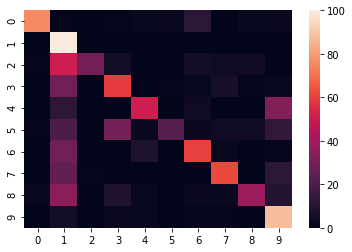

In [24]:
# Plot Confusion matrix
cm = confusion_matrix(true, pred) #pred[::-1]
f = sns.heatmap(cm)

In [25]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(true, pred)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       100
           1       0.33      1.00      0.49       100
           2       0.97      0.30      0.46       100
           3       0.56      0.59      0.57       100
           4       0.75      0.51      0.61       100
           5       0.85      0.22      0.35       100
           6       0.67      0.60      0.63       100
           7       0.77      0.62      0.69       100
           8       0.78      0.39      0.52       100
           9       0.55      0.88      0.67       100

    accuracy                           0.59      1000
   macro avg       0.72      0.59      0.58      1000
weighted avg       0.72      0.59      0.58      1000




>### 👨‍🏫 The `L1-Norm` Algorithm brings solid results with an overall accuracy-value of 59%.
---

## L2-Norm Algorithm

In [26]:
# Create L2 Loss Confusion Matrix
numbers = "zeros,ones,twos,threes,fours,fives,sixs,sevens,eights,nines".split(",")
pred=[]

for number in numbers:
    for t in d_test[number]:
        #mean = h[i]
        # calculate loss for every digit
        loss=[]
        for i in h:
            #loss.append( float(F.l1_loss( t.float(), i)   ))
            loss.append( float(F.mse_loss(t.float(), i).sqrt()))
        # get position of smallest loss (=pred)
        xy = np.argmin(loss)
        pred.append(xy)
        
true=[]
for i in range(10):
    x = [i] * 100
    true=true+x     

In [27]:
confusion_matrix(true, pred)

array([[94,  0,  0,  0,  0,  0,  5,  0,  1,  0],
       [ 0, 92,  0,  0,  0,  0,  1,  0,  7,  0],
       [ 8,  2, 55, 11,  0,  0,  9,  1, 14,  0],
       [ 0,  0,  0, 86,  0,  0,  3,  1,  9,  1],
       [ 5,  0,  0,  0, 62,  0, 10,  1,  4, 18],
       [16,  0,  0, 31,  1,  8,  6,  0, 33,  5],
       [11,  1,  3,  0,  3,  0, 81,  0,  1,  0],
       [ 3,  6,  5,  1,  1,  0,  0, 64, 10, 10],
       [ 4,  0,  0, 15,  1,  0,  2,  2, 76,  0],
       [ 3,  0,  1,  5,  7,  1,  1,  3,  6, 73]])

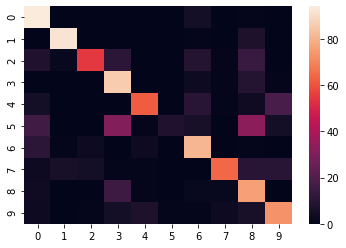

In [28]:
# Plot Confusion matrix
cm = confusion_matrix(true, pred) #pred[::-1]
f = sns.heatmap(cm)

In [29]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(true, pred)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       100
           1       0.91      0.92      0.92       100
           2       0.86      0.55      0.67       100
           3       0.58      0.86      0.69       100
           4       0.83      0.62      0.71       100
           5       0.89      0.08      0.15       100
           6       0.69      0.81      0.74       100
           7       0.89      0.64      0.74       100
           8       0.47      0.76      0.58       100
           9       0.68      0.73      0.71       100

    accuracy                           0.69      1000
   macro avg       0.74      0.69      0.67      1000
weighted avg       0.74      0.69      0.67      1000




>### 👨‍🏫 The `L2-Norm` Algorithm brings even better results with an overall accuracy-value of 69%.
___

# Average-Ink Algorithm

In [30]:
def average_ink(t):
    #average sum of pixelvalues
    x=[]
    for i in range(0,len(t)):
        x.append( int(t[i].sum() ))
    return(x)

In [31]:
y=[]
for number in numbers:
    y.append(average_ink(d[number]))

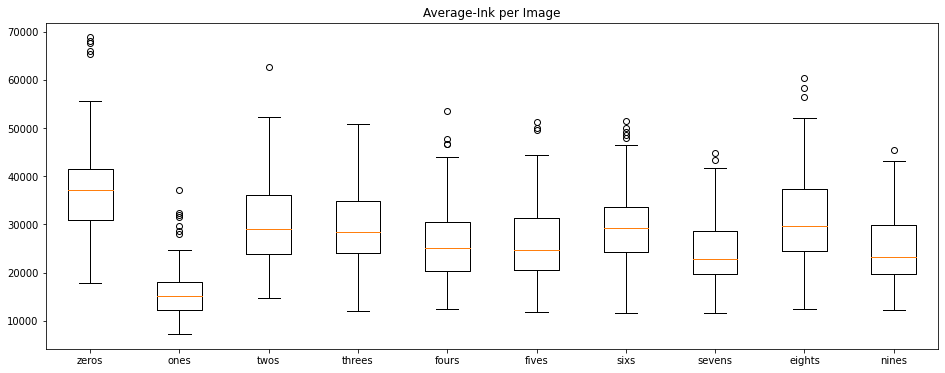

In [32]:
# Create Boxplots of Average-Ink
plt.figure(figsize=(16,6))
plt.boxplot(y)
plt.xticks(range(1,11), numbers)
plt.title("Average-Ink per Image");

In [33]:
def closest(lst, K):
    # returns digit (0..9) according to average pixel value
    x = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(x) 
      
# Driver code
lst = [np.mean(x) for x in y] #list of mean ink values for 0..9

In [34]:
# Get prediction
pred=[]
true=[]
for number in numbers:
    for i in d_test[number]:
        K = i.sum()
        pred.append(closest(lst,K))
        true.append(numbers.index(number))


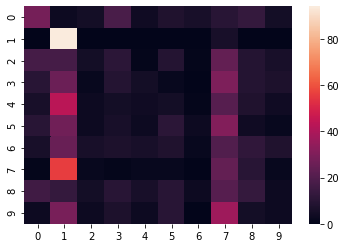

In [35]:
# Plot Confusion matrix
cm = confusion_matrix(true, pred)
f = sns.heatmap(cm)

In [36]:
confusion_matrix(true, pred)

array([[28,  3,  5, 18,  4,  8,  6, 10, 13,  5],
       [ 0, 94,  0,  0,  0,  0,  0,  6,  0,  0],
       [17, 17,  5, 11,  1,  9,  1, 24,  9,  6],
       [10, 26,  2,  9,  5,  2,  0, 30,  9,  7],
       [ 6, 43,  3,  5,  4,  5,  1, 21,  8,  4],
       [10, 27,  3,  6,  3, 11,  3, 31,  4,  2],
       [ 6, 25,  6,  7,  6,  8,  2, 20, 12,  8],
       [ 1, 56,  2,  1,  2,  2,  0, 24, 10,  2],
       [16, 13,  5, 10,  6, 10,  3, 21, 13,  3],
       [ 3, 29,  3,  7,  3, 10,  0, 37,  5,  3]])

In [37]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(true, pred)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.29      0.28      0.28       100
           1       0.28      0.94      0.43       100
           2       0.15      0.05      0.07       100
           3       0.12      0.09      0.10       100
           4       0.12      0.04      0.06       100
           5       0.17      0.11      0.13       100
           6       0.12      0.02      0.03       100
           7       0.11      0.24      0.15       100
           8       0.16      0.13      0.14       100
           9       0.07      0.03      0.04       100

    accuracy                           0.19      1000
   macro avg       0.16      0.19      0.15      1000
weighted avg       0.16      0.19      0.15      1000




>### 👨‍🏫 The `Average-Ink` Algorithms results are disappointing: the average accuracy is only 19% and probably because of its very simply formula so low.  
___

# "Middle-Line" Ratio

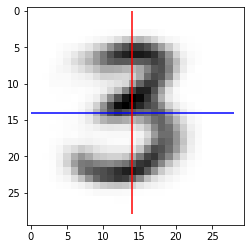

In [38]:
# Print "ideal" 3
t=d["threes"][0]/255
for i in range(len(d["threes"])):
    t+=d["threes"][i]/255
plt.imshow(t)
plt.hlines(y=14, xmin=0.0, xmax=28, color='b')
plt.vlines(x=14, ymin=0.0, ymax=28, color='r')

plt.show()

In [39]:
# function to calculate middle-line-ratio as above described
    
def middle_line_ratio(t):
    #average sum of pixelvalues
    x=[]
    for i in t:
        x.append( float(i[14].sum()) /  float(i[:,14].sum()) )
    return(x)

y=[]
# create middle_line_ratio for every single digit in every number category
for number in numbers:
    y.append(middle_line_ratio(d[number]))

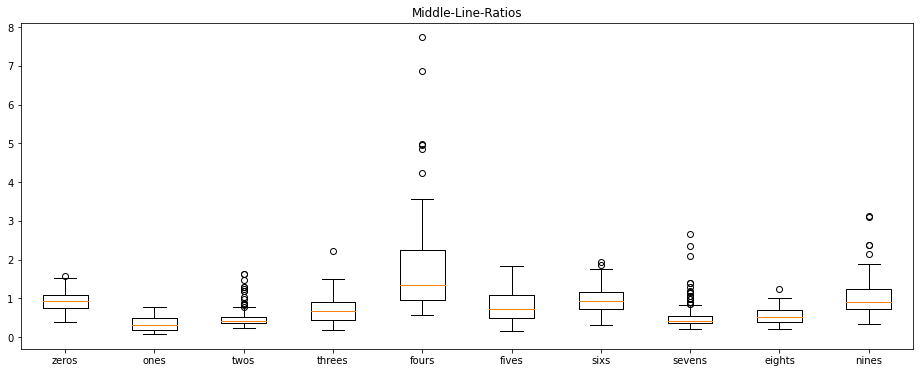

In [40]:
# Create Boxplots of Middle-Line-Ratios
plt.figure(figsize=(16,6))
plt.boxplot(y)
plt.xticks(range(1,11), numbers)
plt.title("Middle-Line-Ratios");

In [41]:
def closest(lst, K):
    # returns digit (0..9) according to middle-line-ratio algorithm
    x = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(x) 
      
# Driver code
lst = [np.mean(x) for x in y] #list of mean ink values for 0..9

In [42]:
# Get prediction
pred=[]
true=[]
for number in numbers:
    for i in d_test[number]:
        #print(type(i))
        K = float(i[14].sum()) /  float(i[:,14].sum())
        pred.append(closest(lst,K))
        true.append(numbers.index(number))


In [43]:
confusion_matrix(true, pred)

array([[10,  0,  2, 11,  3, 25,  6, 12,  0, 31],
       [ 0, 92,  2,  1,  0,  0,  0,  3,  2,  0],
       [ 1, 60, 13,  3,  2,  4,  1,  5,  5,  6],
       [ 5, 43,  7, 11,  1, 14,  1,  6,  1, 11],
       [ 0,  2,  5,  7, 60,  6,  1,  1,  0, 18],
       [ 1, 29, 10, 13,  9,  6,  6, 10,  2, 14],
       [ 7, 14, 10,  4, 20,  7,  4, 12,  1, 21],
       [ 3, 64,  6,  3,  3,  7,  2,  8,  1,  3],
       [ 3, 29, 21, 17,  3,  7,  3,  9,  3,  5],
       [ 3, 11,  0,  3, 30, 15,  2,  5,  1, 30]])

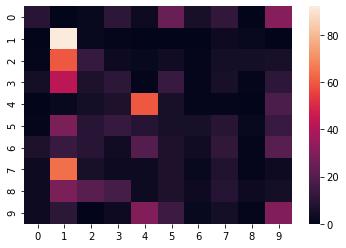

In [44]:
# Plot Confusion matrix
cm = confusion_matrix(true, pred) 
f = sns.heatmap(cm)

In [45]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(true, pred)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.30      0.10      0.15       100
           1       0.27      0.92      0.41       100
           2       0.17      0.13      0.15       100
           3       0.15      0.11      0.13       100
           4       0.46      0.60      0.52       100
           5       0.07      0.06      0.06       100
           6       0.15      0.04      0.06       100
           7       0.11      0.08      0.09       100
           8       0.19      0.03      0.05       100
           9       0.22      0.30      0.25       100

    accuracy                           0.24      1000
   macro avg       0.21      0.24      0.19      1000
weighted avg       0.21      0.24      0.19      1000




>### 👨‍🏫 The `Middle-Line-Ratio` Algorithm is almost as disappointing as the Average-Ink Algorithm. The average accuracy is only 24%.
___

# "Random Points" Algorithm

This Algorithms choses simple points (I chose 2 points) and sums its pixel value up. This again gives a ideal target value for every digit 0..9.

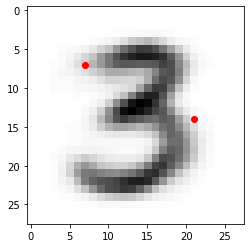

In [46]:
# Print "ideal" 3
t=d["threes"][0]/255
for i in range(len(d["threes"])):
    t+=d["threes"][i]/255
plt.imshow(t)
#plt.plot(105,200,'ro')
plt.plot(7,7, 'ro')
plt.plot(21,14, 'ro')

plt.show()

In [47]:
# function to calculate Random Points Algorithm as above described
    
def middle_line_ratio(t):
    #average sum of pixelvalues
    x=[]
    for i in t:
        x.append( float(i[7,7].sum()) +  float(i[21,14].sum()) )
    return(x)

y=[]
# create middle_line_ratio for every single digit in every number category
for number in numbers:
    y.append(middle_line_ratio(d[number]))

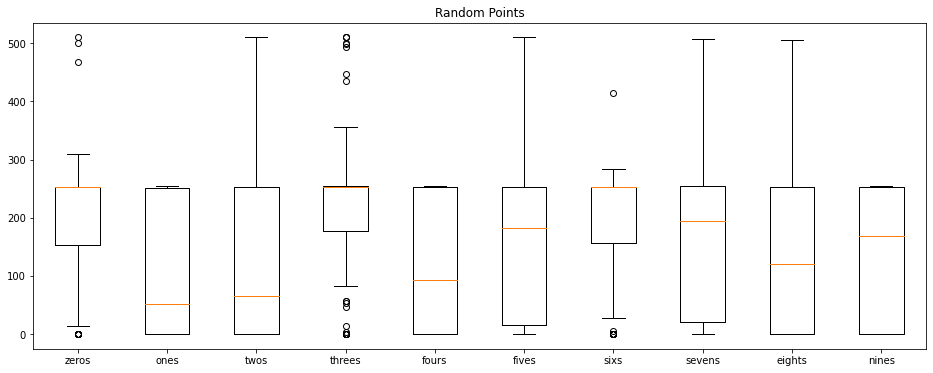

In [48]:
# Create Boxplots of Random Points
plt.figure(figsize=(16,6))
plt.boxplot(y)
plt.xticks(range(1,11), numbers)
plt.title("Random Points");

In [49]:
def closest(lst, K):
    # returns digit (0..9) according to average pixel value
    x = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(x) 
      
# Driver code
lst = [np.mean(x) for x in y] #list of Random Points for 0..9

In [50]:
# Get prediction
pred=[]
true=[]
for number in numbers:
    for i in d_test[number]:
        #print(type(i))
        K = float(i[7,7].sum()) +  float(i[21,14].sum())
        pred.append(closest(lst,K))
        true.append(numbers.index(number))

In [51]:
confusion_matrix(true, pred)

array([[ 4, 27,  0, 53,  0,  6,  2,  5,  1,  2],
       [ 7, 30,  0, 50,  0,  2,  4,  4,  2,  1],
       [ 3, 34,  3, 50,  1,  1,  4,  3,  0,  1],
       [ 5, 29,  2, 53,  4,  2,  2,  1,  0,  2],
       [ 3, 61,  0, 26,  1,  5,  1,  3,  0,  0],
       [ 0, 48,  0, 41,  0,  3,  1,  6,  1,  0],
       [ 7, 16,  0, 65,  0,  5,  6,  1,  0,  0],
       [ 3, 37,  0, 54,  0,  1,  1,  1,  2,  1],
       [ 3, 53,  1, 35,  0,  0,  2,  4,  1,  1],
       [ 6, 64,  1, 17,  2,  3,  4,  2,  1,  0]])

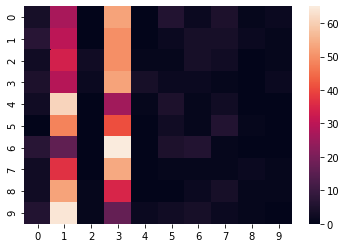

In [52]:
# Plot Confusion matrix
cm = confusion_matrix(true, pred) #pred[::-1]
f = sns.heatmap(cm)

In [53]:
print(f"Classification report for classifier:\n"
      f"{metrics.classification_report(true, pred)}\n")

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.10      0.04      0.06       100
           1       0.08      0.30      0.12       100
           2       0.43      0.03      0.06       100
           3       0.12      0.53      0.19       100
           4       0.12      0.01      0.02       100
           5       0.11      0.03      0.05       100
           6       0.22      0.06      0.09       100
           7       0.03      0.01      0.02       100
           8       0.12      0.01      0.02       100
           9       0.00      0.00      0.00       100

    accuracy                           0.10      1000
   macro avg       0.13      0.10      0.06      1000
weighted avg       0.13      0.10      0.06      1000




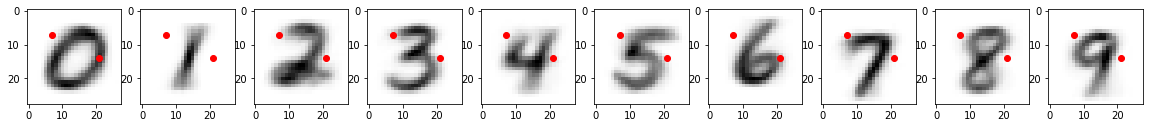

In [54]:
# Print "ideal" digits
h=[]
for number in numbers:
    t=d[number][0]/255
    for i in range(len(d[number])):
        t+=d[number][i]/255
    h.append(t)
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,8))
for i in range(0,10):
    axes[i].imshow(h[i])
    axes[i].plot(7,7, 'ro')
    axes[i].plot(21,14, 'ro')

We can see that the efficency of this algorithms relies heavily on where the points are placed. The two values I chose very by far not ideal placed as we can see from above graphic. So it probably will result in better accuracy values with more points and better places points (e.g. the white space within the 9 or 8, etc.). But keep in mind that the more points this algorithms uses the more it brings the same results as the `Average-Ink` Algorithm.

👨‍🏫 The `Random-Points` Algorithm gives only 10% accuracy. But it heavily depends on where to place the points and how many. So it is improvable ...